<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/Mining_frequent_subgraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [34]:
df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
df

,login,name
0,vim-sroberge,vimaec/g3d
1,vim-sroberge,vimaec/g3d
2,vim-sroberge,vimaec/g3d
3,vim-sroberge,vimaec/g3d
4,mavimaec,vimaec/g3d
...,...,...
1328,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1329,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1330,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1331,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples


In [35]:
df['login'] = df['login'].apply(lambda x: 'User: '+x)
df['name'] = df['name'].apply(lambda x: 'Repo: '+x)

In [36]:
# Build the adjacency matrix
adj_matrix = pd.crosstab(df['login'], df['name']).astype(float)
idx = adj_matrix.columns.union(adj_matrix.index)
adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

In [37]:
G = nx.from_numpy_matrix(adj_matrix.to_numpy())
print(nx.info(G))

Graph with 262 nodes and 192 edges


In [38]:
matrix_elements = np.sort(df['login'].unique(), axis=0)
repo_len = len(df['name'].unique())

def  cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

#Initialise an auxiliar matrix to record the user - user similarities
shape = (len(matrix_elements), len(matrix_elements))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

for i in matrix_elements:
    for j in matrix_elements:

        # Compare row vectors
        aux_vector_a = adj_matrix.loc[i].to_numpy()[:repo_len]
        aux_vector_b = adj_matrix.loc[j].to_numpy()[:repo_len]
        
        score = cosine_similarity(aux_vector_a, aux_vector_b)
        aux_matrix.at[i, j] = score

In [39]:
# Set the diagonal to 0 (Same user-user interaction = 0)
np.fill_diagonal(aux_matrix.to_numpy(), 0)

In [40]:
# Fill adj_matrix with aux_matrix data
for column in aux_matrix.columns:
    for row in aux_matrix.index:

        aux = aux_matrix.at[row, column]
        adj_matrix.at[row, column] = aux


In [41]:
G = nx.from_numpy_matrix(adj_matrix.to_numpy())
print(nx.info(G))

Graph with 262 nodes and 519 edges


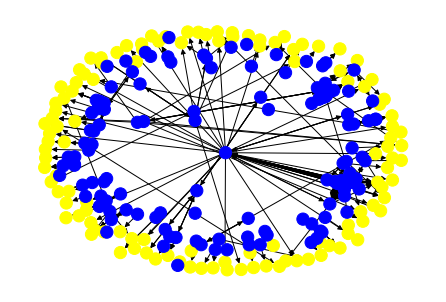

In [45]:
# Initialise the grah
## Since I deleted the user edge to itself (Set user-user diagonal to 0), 
## I changed the type of graph from multigraph to DiGraph, just for edges visualisation purposes.
G = nx.DiGraph()


# Save edges with their weights
edges = []

for row in adj_matrix.index:
    vector = adj_matrix.loc[row].to_numpy()
    for i, j in zip(vector, adj_matrix.columns):
        if i > 0:
            edges.append((row[6:],j[6:],i)) # for nx.Graph() use edges.append((row[6:],j[6:],{'weight': i}))
 
# Save nodes
nodes = []

for name in adj_matrix.index:
    if name.startswith('User: '):
        nodes.append((name[6:],{"color": "blue"})) #Users are blue
    elif name.startswith('Repo: '):
        nodes.append((name[6:],{"color": "yellow"})) #Repos are yellow

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)    # for nx.Graph() use edges.add_edges_from(edges)
pos = nx.spring_layout(G, seed=52)  # positions for all nodes
# Set nodes colors, blue for users, yellow for repos.
colors = nx.get_node_attributes(G, "color")
node_colors = [colors.get(node) for node in G.nodes()]

# List all users #https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling
users = [key for key,value in nx.get_node_attributes(G,'color').items() if value == 'blue']
labels = {}    
for node in G.nodes():
    if node in users:
        labels[node] = node


fig = plt.figure(1)
nx.draw(G,pos = pos, node_color=node_colors, node_size=150, with_labels=False)
plt.show()

In [47]:
# Weakly connected components: There is a directed path from node A to node B but not necessarily from node B to node A.

nx.number_weakly_connected_components(G)

74

In [48]:
[len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]

[42,
 18,
 8,
 7,
 7,
 6,
 6,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [64]:
connected_components = list(nx.weakly_connected_components(G))

In [118]:
node = 'ralphnuessecpwr'       #'fabiocosta0305'

def get_component(node, connected_components):
  for component in connected_components:
    if node in component:
      return component
  else:
    return set()


get_component(node, connected_components)

{'CPWRGIT',
 'CPWRGIT/HDDRXM0',
 'CPWRGIT/HDDRXM02',
 'CPWRGIT/HDDRXM0_CWC2',
 'CPWRGIT/ISPWSA0',
 'CPWRGIT/ISPWSA0_CWC2',
 'ralphnuessecpwr',
 'stupot1966'}

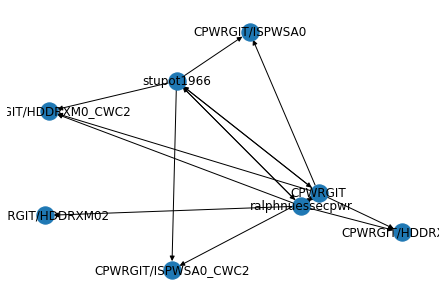

In [119]:
T = nx.subgraph(G, list(get_component(node, connected_components)))
nx.draw(T, with_labels=True)

In [120]:
sub_am = nx.to_pandas_adjacency(G, list(get_component(node, connected_components)))
sub_am

,stupot1966,CPWRGIT/HDDRXM02,CPWRGIT/HDDRXM0_CWC2,CPWRGIT/HDDRXM0,CPWRGIT/ISPWSA0,CPWRGIT,ralphnuessecpwr,CPWRGIT/ISPWSA0_CWC2
stupot1966,0.000000,0.0,22.0,0.0,50.0,0.085363,0.042369,3.0
CPWRGIT/HDDRXM02,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
CPWRGIT/HDDRXM0_CWC2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
CPWRGIT/HDDRXM0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
CPWRGIT/ISPWSA0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
CPWRGIT,0.085363,0.0,8.0,92.0,5.0,0.000000,0.997107,2.0
ralphnuessecpwr,0.042369,6.0,14.0,132.0,0.0,0.997107,0.000000,0.0
CPWRGIT/ISPWSA0_CWC2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [121]:
# Maybe: keep iterating (shuffling) until .loc[node,node] = 0.0
aux = False
while aux is False:
  np.random.shuffle(sub_am.loc[node])
  if sub_am.loc[node,node] == 0.0:
    aux = True

sub_am

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  after removing the cwd from sys.path.


,stupot1966,CPWRGIT/HDDRXM02,CPWRGIT/HDDRXM0_CWC2,CPWRGIT/HDDRXM0,CPWRGIT/ISPWSA0,CPWRGIT,ralphnuessecpwr,CPWRGIT/ISPWSA0_CWC2
stupot1966,0.000000,0.0,22.000000,0.000000,50.0,0.085363,0.042369,3.0
CPWRGIT/HDDRXM02,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
CPWRGIT/HDDRXM0_CWC2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
CPWRGIT/HDDRXM0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
CPWRGIT/ISPWSA0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
CPWRGIT,0.085363,0.0,8.000000,92.000000,5.0,0.000000,0.997107,2.0
ralphnuessecpwr,6.000000,0.0,0.042369,0.997107,0.0,14.000000,0.000000,132.0
CPWRGIT/ISPWSA0_CWC2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


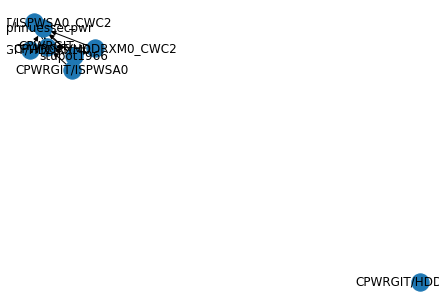

In [122]:
S = nx.from_pandas_adjacency(sub_am)
nx.draw(S, with_labels=True, arrows=True)

In [123]:
d = {'degree_centrality' : nx.degree_centrality(T),
     'eigenvector_centrality' : nx.eigenvector_centrality(T),
     'closeness_centrality' : nx.closeness_centrality(T),
     'betweenness_centrality' : nx.betweenness_centrality(T)}

pd.DataFrame(d)

,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
stupot1966,1.000000,0.342997,0.285714,0.023810
CPWRGIT/HDDRXM02,0.142857,0.171500,0.257143,0.000000
CPWRGIT/HDDRXM0_CWC2,0.428571,0.514495,0.428571,0.000000
CPWRGIT/HDDRXM0,0.285714,0.342997,0.321429,0.000000
CPWRGIT/ISPWSA0,0.285714,0.342997,0.321429,0.000000
CPWRGIT,1.142857,0.342997,0.285714,0.035714
ralphnuessecpwr,1.000000,0.342997,0.285714,0.059524
CPWRGIT/ISPWSA0_CWC2,0.285714,0.342997,0.321429,0.000000


In [124]:
d = {'degree_centrality' : nx.degree_centrality(S),
     'eigenvector_centrality' : nx.eigenvector_centrality(S),
     'closeness_centrality' : nx.closeness_centrality(S),
     'betweenness_centrality' : nx.betweenness_centrality(S)}

pd.DataFrame(d)

,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
stupot1966,0.714286,4.534174e-01,0.734694,0.087302
CPWRGIT/HDDRXM02,0.000000,1.632689e-07,0.000000,0.000000
CPWRGIT/HDDRXM0_CWC2,0.428571,3.414618e-01,0.571429,0.000000
CPWRGIT/HDDRXM0,0.285714,2.313028e-01,0.514286,0.000000
CPWRGIT/ISPWSA0,0.285714,2.313028e-01,0.514286,0.000000
CPWRGIT,0.857143,4.986291e-01,0.857143,0.206349
ralphnuessecpwr,0.714286,4.534174e-01,0.734694,0.087302
CPWRGIT/ISPWSA0_CWC2,0.428571,3.414618e-01,0.571429,0.000000
